In [1]:
import autoroot
from typing import Optional, Callable
import toolz 
import functools as ft
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm.auto as tqdm
from rastervision.core.data import RasterioSource, XarraySource
import xarray as xr
import rioxarray
from pyproj import CRS
import cartopy.crs as ccrs

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

2024-01-11 19:44:56:rastervision.pipeline.rv_config: WARNING - Root temporary directory cannot be used: /opt/data/tmp. Using root: /tmp/tmpcmy988kp


Get example filenames

In [2]:
!ls /home/juanjohn/data/rs/goes/noaa-goes16/ABI-L1b-RadF/2020/293/12

OR_ABI-L1b-RadF-M6C01_G16_s20202931200187_e20202931209495_c20202931209553.nc
OR_ABI-L1b-RadF-M6C02_G16_s20202931200187_e20202931209495_c20202931209540.nc
OR_ABI-L1b-RadF-M6C03_G16_s20202931200187_e20202931209495_c20202931209556.nc
OR_ABI-L1b-RadF-M6C04_G16_s20202931200187_e20202931209495_c20202931209527.nc
OR_ABI-L1b-RadF-M6C05_G16_s20202931200187_e20202931209495_c20202931209550.nc
OR_ABI-L1b-RadF-M6C06_G16_s20202931200187_e20202931209501_c20202931209546.nc
OR_ABI-L1b-RadF-M6C07_G16_s20202931200187_e20202931209507_c20202931209561.nc
OR_ABI-L1b-RadF-M6C08_G16_s20202931200187_e20202931209495_c20202931209566.nc
OR_ABI-L1b-RadF-M6C09_G16_s20202931200187_e20202931209501_c20202931209555.nc
OR_ABI-L1b-RadF-M6C10_G16_s20202931200187_e20202931209506_c20202931209566.nc
OR_ABI-L1b-RadF-M6C11_G16_s20202931200187_e20202931209495_c20202931209552.nc
OR_ABI-L1b-RadF-M6C12_G16_s20202931200187_e20202931209501_c20202931209577.nc
OR_ABI-L1b-RadF-M6C13_G16_s20202931200187_e20202931209506_c20202931209582.nc

In [3]:
import glob, os

def get_list_filenames(data_path: str="./", ext: str="*"):
    """Loads a list of file names within a directory
    """
    pattern = f"*{ext}"
    return sorted(glob.glob(os.path.join(data_path, "**", pattern), recursive=True))

In [4]:
base_path = "/home/juanjohn/data/rs/goes/noaa-goes16/ABI-L1b-RadF/2020/293/12"
ext = ".nc"

data_filenames = get_list_filenames(base_path, ext)
print(len(data_filenames))

16


Load data

In [5]:
xr_ds = xr.open_dataset(data_filenames[0])
xr_da = xr_ds.Rad

In [6]:
xr_ds

<xarray.Dataset>
Dimensions:                                           (y: 10848, x: 10848,
                                                       number_of_time_bounds: 2,
                                                       number_of_image_bounds: 2,
                                                       band: 1,
                                                       num_star_looks: 24)
Coordinates:
    t                                                 datetime64[ns] ...
  * y                                                 (y) float64 0.1519 ... ...
  * x                                                 (x) float64 -0.1519 ......
    y_image                                           float32 ...
    x_image                                           float32 ...
    band_id                                           (band) int8 ...
    band_wavelength                                   (band) float32 ...
    t_star_look                                       (num_star_looks) datetime64[ns] ...
    band_wavelength_star_look                         (num_star_looks) float32 ...
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
                                band, num_star_looks
Data variables: (12/37)
    Rad                                               (y, x) float32 ...
    DQF                                               (y, x) float32 ...
    time_bounds                                       (number_of_time_bounds) datetime64[ns] ...
    goes_imager_projection                            int32 ...
    y_image_bounds                                    (number_of_image_bounds) float32 ...
    x_image_bounds                                    (number_of_image_bounds) float32 ...
    ...                                                ...
    algorithm_dynamic_input_data_container            int32 ...
    processing_parm_version_container                 int32 ...
    algorithm_product_version_container               int32 ...
    star_id                                           (num_star_looks) float32 ...
    channel_integration_time                          float64 ...
    channel_gain_field                                float64 ...
Attributes: (12/30)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    production_site:           WCDAS
    ...                        ...
    timeline_id:               ABI Mode 6
    date_created:              2020-10-19T12:09:55.3Z
    time_coverage_start:       2020-10-19T12:00:18.7Z
    time_coverage_end:         2020-10-19T12:09:49.5Z
    LUT_Filenames:             SpaceLookParams(FM1A_CDRL79RevP_PR_09_00_02)-6...
    id:                        f96d9208-8455-4255-80ae-bec31f065387

In [7]:
def reproject_goes(ds, crs_projection: str="EPSG:4326") -> xr.Dataset:

    # get perspective height
    sat_height = ds.goes_imager_projection.attrs["perspective_point_height"]

    # reassign coordinates to correct height
    ds = ds.assign_coords({"x": ds.x.values * sat_height})
    ds = ds.assign_coords({"y": ds.y.values * sat_height})

    # load CRS
    cc = CRS.from_cf(ds.goes_imager_projection.attrs)

    # assign CRS to dataarray
    ds =  ds.rio.write_crs(cc.to_string(), inplace=False)

    # reproject to desired coordinate system
    ds = ds.rio.reproject(crs_projection)
    
    return ds

In [8]:
import pyinterp
import pyinterp.backends.xarray
import pyinterp.tests

In [9]:
def preprocess(ds):
    # # resize, e.g., coarsen, select subset
    # ds = ds.coarsen(x=10, y=10, boundary="trim").mean()
    indices = slice(0, None, 8)
    ds = ds.isel(x=indices, y=indices)

    # extract variables of interest, e.g., RAD
    ds = ds[["Rad", "goes_imager_projection"]]
    
    # reproject, e.g., EPSG:4326
    ds = reproject_goes(ds)
    
    # compute transformation, e.g., reflectance
    
    return ds

In [56]:
# populates the search tree

def create_goes_interp_mesh(ds, variable: str="Rad"):

    mesh = pyinterp.RTree()

    # extract coordinates - 2D vector
    X, Y = np.meshgrid(ds.x.values, ds.y.values)

    # ravel them - 1D vectors
    X, Y = X.ravel(), Y.ravel()

    mesh.packing(
        np.vstack((X,Y )).T,
        ds["Rad"].values.ravel()
    )
    return mesh

SCALE_NUM_PTS = {
    "1": 10_848,
    "0.5": 21_696,
    "2": 5_424,
}

X0, X1 = - 0.15185800194740295, 0.15185800221843238

def create_goes_coords(scale: str="1"):

    DX = SCALE_NUM_PTS[scale]

    # create coordinate vector
    x_coords = np.linspace(X0, X1, DX)
    


    return X.ravel(), Y.ravel()

In [44]:
def resample_goes(ds, scale: str="1"):

    # create interpolation mesh
    mesh = create_goes_interp_mesh(ds)

    # create query coordinates
    x_coords = create_goes_coords(scale=scale)

    # create meshgrid
    X, Y = np.meshgrid(x_coords, x_coords)

    # Inverse Distance Weighting
    idw_eta, neighbors = mesh.inverse_distance_weighting(
        np.vstack((X.ravel(), Y.ravel())).T,
        within=True,  # Extrapolation is forbidden
        radius=55000,  # In a radius of 5.5 Km
        k=8,  # We are looking for at most 8 neighbours
        num_threads=0)
    idw_eta = idw_eta.reshape(X.shape)

    # create new dataset
    ds = xr.Dataset(
        {"Rad": (("band","x", "y"), idw_eta)},
        coords = {"x": (("x"), x_coords),
                  "y": (("y"), x_coords),
                  "band": ds.band_id.values}
    )

    return ds

$$
\begin{aligned}
L &= |x_\text{max} - x_\text{min}| \\
\Delta x &= L / (N - 1)
\end{aligned}
$$

In [10]:
def bounds_and_points_to_step(xmin: float, xmax: float, Nx: float) -> float:
    """Calculates the dx from the minmax
    Eq:
        Lx = abs(xmax - xmin)
        dx = Lx / (Nx - 1)

    Args:
        xmin (Array | float): the input start point
        xmax (Array | float): the input end point
        Nx (int | float): the number of points

    Returns:
        dx (Array | float): the distance between each of the
            steps.
    """
    Lx = abs(float(xmax) - float(xmin))
    return float(Lx) / (float(Nx) - 1.0)

In [53]:
NUM_PTS = {
    "1": 10_848,
    "2": 21_696,
    "3": 10_848,
    "4": 5_424,
    "5": 10_848,
    "6": 5_424,
    "7": 5_424,
    "8": 5_424,
    "9": 5_424,
    "10": 5_424,
    "11": 5_424,
    "12": 5_424,
    "13": 5_424,
    "14": 5_424,
    "15": 5_424,
    "16": 5_424,
}

DX = {
    "10848": 2.8000000384054147e-05,
    "21_696": 1.3999354882038965e-05,
    "5_424": 5.600516396198328e-05,
}

In [12]:


out = np.linspace(x0, x1, 10848)
out.shape, out.min(), out.max()

((10848,), -0.15185800194740295, 0.15185800221843238)

In [29]:
def calc_latlon(ds):
    '''
    Takes GOES dataset (one image) and computes latitude and 
    longitude for each pixel using horizontal scan angles x
    and vertical scan angles y.

    Input:
        ds  xarray.Dataset
    Output:
        ds  xarray.Dataset with lat and lon values added for each datapoint
            and used as indeces.
    '''
    # The math for this function was taken from 
    # https://makersportal.com/blog/2018/11/25/goes-r-satellite-latitude-and-longitude-grid-projection-algorithm 

    x = ds.x
    y = ds.y
    goes_imager_projection = ds.goes_imager_projection
    
    x,y = np.meshgrid(x,y)
    
    r_eq = goes_imager_projection.attrs["semi_major_axis"] # earth radius at equator
    r_pol = goes_imager_projection.attrs["semi_minor_axis"] # earth radius at pole
    l_0 = goes_imager_projection.attrs["longitude_of_projection_origin"] * (np.pi/180) # lambda0
    h_sat = goes_imager_projection.attrs["perspective_point_height"] # distance satellite to nearest equator surface point
    H = r_eq + h_sat # distance satellite to earth centre
    
    a = np.sin(x)**2 + (np.cos(x)**2 * (np.cos(y)**2 + (r_eq**2 / r_pol**2) * np.sin(y)**2))
    b = -2 * H * np.cos(x) * np.cos(y)
    c = H**2 - r_eq**2
    
    r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)
    
    s_x = r_s * np.cos(x) * np.cos(y)
    s_y = -r_s * np.sin(x)
    s_z = r_s * np.cos(x) * np.sin(y)

    # latitude and longitude
    lat = np.arctan((r_eq**2 / r_pol**2) * (s_z / np.sqrt((H-s_x)**2 +s_y**2))) * (180/np.pi)
    lon = (l_0 - np.arctan(s_y / (H-s_x))) * (180/np.pi)
    
    # ds = ds.assign_coords({
    #     "lat":(["y","x"],lat),
    #     "lon":(["y","x"],lon)
    # })
    # ds.lat.attrs["units"] = "degrees_north"
    # ds.lon.attrs["units"] = "degrees_east"

    return lat, lon

def get_xy_from_latlon(ds, lats, lons):
    lat1, lat2 = lats
    lon1, lon2 = lons

    lat = ds.lat.data
    lon = ds.lon.data
    
    x = ds.x.data
    y = ds.y.data
    
    x,y = np.meshgrid(x,y)
    
    x = x[(lat >= lat1) & (lat <= lat2) & (lon >= lon1) & (lon <= lon2)]
    y = y[(lat >= lat1) & (lat <= lat2) & (lon >= lon1) & (lon <= lon2)] 
    
    return ((min(x), max(x)), (min(y), max(y)))

In [13]:
def get_crs(ds):
    """Cartopy coordinate reference system for the Satellite."""
    if ds.cdm_data_type == "Image":
        globe_kwargs = dict(
            semimajor_axis=ds.goes_imager_projection.semi_major_axis,
            semiminor_axis=ds.goes_imager_projection.semi_minor_axis,
            inverse_flattening=ds.goes_imager_projection.inverse_flattening,
        )
        sat_height = ds.goes_imager_projection.perspective_point_height
        nadir_lon = ds.geospatial_lat_lon_extent.geospatial_lon_nadir
        nadir_lat = ds.geospatial_lat_lon_extent.geospatial_lat_nadir
    elif ds.cdm_data_type == "Point":
        globe_kwargs = dict(
            semimajor_axis=ds.goes_lat_lon_projection.semi_major_axis,
            semiminor_axis=ds.goes_lat_lon_projection.semi_minor_axis,
            inverse_flattening=ds.goes_lat_lon_projection.inverse_flattening,
        )
        sat_height = ds.nominal_satellite_height.item() * 1000
        nadir_lon = ds.lon_field_of_view.item()
        nadir_lat = ds.lat_field_of_view.item()
    # Create a cartopy coordinate reference system (crs)
    globe = ccrs.Globe(ellipse=None, **globe_kwargs)

    crs = ccrs.Geostationary(
        central_longitude=nadir_lon,
        satellite_height=sat_height,
        globe=globe,
        sweep_axis="x",
    )
    return crs

In [25]:
def get_goes_xy_coords(ds, crs):

    # get perspective height
    sat_height = ds.goes_imager_projection.attrs["perspective_point_height"]

    # get coordinates
    X, Y = np.meshgrid(ds.x * sat_height, ds.y * sat_height)

    # transform coordinates
    a = ccrs.PlateCarree().transform_points(crs, X, Y)

    print(a.min(), a.max())
    
    lons, lats = a[:, :, 0], a[:, :, 1]
    return lons, lats

In [26]:
crs_ = get_crs(xr_ds)
lons, lats = get_goes_xy_coords(xr_ds, crs_)
lons.shape, lats.shape

nan nan


((10848, 10848), (10848, 10848))

In [24]:
lats.min(), lats.max()

(nan, nan)

In [88]:
X, Y = np.meshgrid(ids.x, ids.y)

In [89]:
a = ccrs.PlateCarree().transform_points(crs_, X, Y)

In [95]:
a[:,:,0].min(), a[:,:,0].max()

(-75.00000136403754, -74.99999863596177)

In [42]:
ids.Rad.values.shape, ids.x.values.shape

((5424, 5424), (5424,))

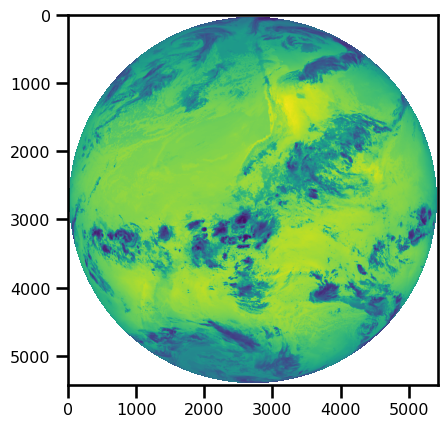

In [48]:
plt.imshow(idw_eta)

In [53]:
import cartopy.crs as ccrs




In [52]:
for i, ifile in enumerate(data_filenames):
    ids = xr.open_dataset(ifile)
    # lat, lon = calc_latlon(ids)
    # get band
    band = ids.band_id.values[0]
    # calculate # pixels
    step = bounds_and_points_to_step(x0, x1, NUM_PTS[str(band)])
    print(f"Band: {i} | Step: {step}")
    

Band: 0 | Step: 1.3999354882038965e-05
Band: 1 | Step: 2.8000000384054147e-05
Band: 2 | Step: 5.600516396198328e-05
Band: 3 | Step: 2.8000000384054147e-05
Band: 4 | Step: 5.600516396198328e-05
Band: 5 | Step: 5.600516396198328e-05
Band: 6 | Step: 5.600516396198328e-05
Band: 7 | Step: 5.600516396198328e-05
Band: 8 | Step: 5.600516396198328e-05
Band: 9 | Step: 5.600516396198328e-05
Band: 10 | Step: 5.600516396198328e-05
Band: 11 | Step: 5.600516396198328e-05
Band: 12 | Step: 5.600516396198328e-05
Band: 13 | Step: 5.600516396198328e-05
Band: 14 | Step: 5.600516396198328e-05
Band: 15 | Step: 5.600516396198328e-05


In [30]:
xr_ds = xr.open_mfdataset(
    data_filenames[1], 
    preprocess=preprocess, 
    concat_dim="band", 
    combine="nested",
    parallel=False,
    engine="netcdf4",
)
xr_ds

<xarray.Dataset>
Dimensions:                 (x: 2856, y: 2560, band: 1)
Coordinates:
  * x                       (x) float64 -156.2 -156.2 -156.1 ... 5.899 5.955
  * y                       (y) float64 72.77 72.71 72.66 ... -72.55 -72.61
    x_image                 float32 0.0
    y_image                 float32 0.0
    t                       datetime64[ns] 2020-10-19T12:05:04.145756032
    goes_imager_projection  int64 0
Dimensions without coordinates: band
Data variables:
    Rad                     (band, y, x) float32 nan nan nan nan ... nan nan nan
Attributes: (12/30)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    production_site:           WCDAS
    ...                        ...
    timeline_id:               ABI Mode 6
    date_created:              2020-10-19T12:09:54.0Z
    time_coverage_start:       2020-10-19T12:00:18.7Z
    time_coverage_end:         2020-10-19T12:09:49.5Z
    LUT_Filenames:             SpaceLookParams(FM1A_CDRL79RevP_PR_09_00_02)-6...
    id:                        bee279a2-ca02-46ef-9474-e1ae36305c11

In [20]:
xr_ds

<xarray.Dataset>
Dimensions:                 (x: 753, y: 593, band: 1)
Coordinates:
  * x                       (x) float64 -156.1 -155.9 -155.7 ... 3.732 3.945
  * y                       (y) float64 63.18 62.97 62.75 ... -62.61 -62.82
    x_image                 float32 0.0
    y_image                 float32 0.0
    t                       datetime64[ns] 2020-10-19T12:05:04.143604096
    goes_imager_projection  int64 0
Dimensions without coordinates: band
Data variables:
    Rad                     (band, y, x) float32 nan nan nan nan ... nan nan nan
Attributes: (12/30)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    production_site:           WCDAS
    ...                        ...
    timeline_id:               ABI Mode 6
    date_created:              2020-10-19T12:09:52.7Z
    time_coverage_start:       2020-10-19T12:00:18.7Z
    time_coverage_end:         2020-10-19T12:09:49.5Z
    LUT_Filenames:             SpaceLookParams(FM1A_CDRL79RevP_PR_09_00_02)-6...
    id:                        e978d964-496a-4f1c-bfc2-f2c001f73103

In [41]:
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [42]:
xr_ds.Rad

<xarray.DataArray 'Rad' (band: 1, y: 2560, x: 2856)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * x                       (x) float64 -156.2 -156.2 -156.1 ... 5.899 5.955
  * y                       (y) float64 72.77 72.71 72.66 ... -72.55 -72.61
    x_image                 float32 0.0
    y_image                 float32 0.0
    t                       datetime64[ns] 2020-10-19T00:05:03.716264064
    goes_imager_projection  int64 0
Dimensions without coordinates: band
Attributes:
    long_name:              ABI L1b Radiances
    standard_name:          toa_outgoing_radiance_per_unit_wavelength
    sensor_band_bit_depth:  12
    valid_range:            [   0 4094]
    units:                  W m-2 sr-1 um-1
    resolution:             y: 0.000014 rad x: 0.000014 rad
    grid_mapping:           goes_imager_projection
    cell_methods:           t: point area: point
    ancillary_variables:    DQF

In [43]:
xr_ds.Rad

<xarray.DataArray 'Rad' (band: 1, y: 2560, x: 2856)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * x                       (x) float64 -156.2 -156.2 -156.1 ... 5.899 5.955
  * y                       (y) float64 72.77 72.71 72.66 ... -72.55 -72.61
    x_image                 float32 0.0
    y_image                 float32 0.0
    t                       datetime64[ns] 2020-10-19T00:05:03.716264064
    goes_imager_projection  int64 0
Dimensions without coordinates: band
Attributes:
    long_name:              ABI L1b Radiances
    standard_name:          toa_outgoing_radiance_per_unit_wavelength
    sensor_band_bit_depth:  12
    valid_range:            [   0 4094]
    units:                  W m-2 sr-1 um-1
    resolution:             y: 0.000014 rad x: 0.000014 rad
    grid_mapping:           goes_imager_projection
    cell_methods:           t: point area: point
    ancillary_variables:    DQF

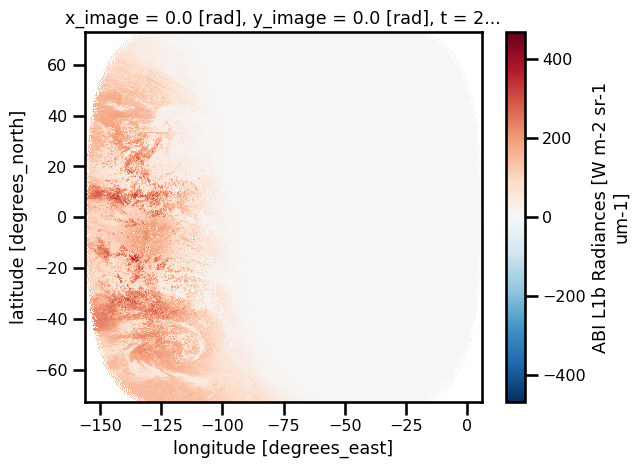

In [44]:
fig, ax = plt.subplots()
band = 0
xr_ds.isel(band=band).Rad.plot.imshow(ax=ax)
# xr_ds.Rad.plot.imshow(ax=ax)

plt.show()

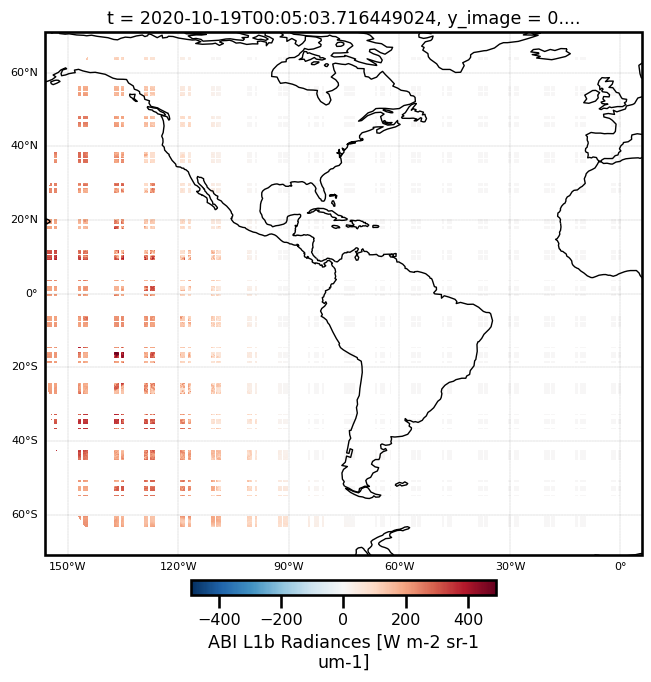

In [14]:
fig, ax = plt.subplots(figsize=(10,7), subplot_kw={'projection': ccrs.PlateCarree()})

step = 0
band = 0
cbar_kwargs = {
    "fraction": 0.027, 
    "pad": 0.045, 
    "orientation": "horizontal"
}
xr_ds.isel(band=band).Rad.plot.pcolormesh(ax=ax, cmap="RdBu_r", transform=ccrs.PlateCarree(), cbar_kwargs=cbar_kwargs)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='k', alpha=1, 
                  linestyle='--')

ax.coastlines(linewidth=1)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8} 

plt.tight_layout()
plt.show()

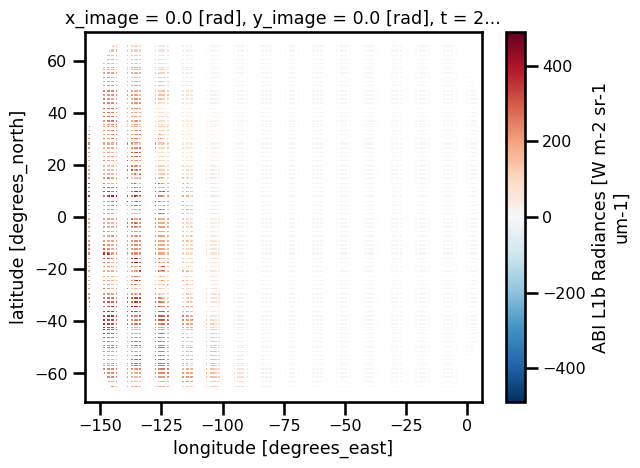

In [65]:
fig, ax = plt.subplots()

xr_ds.Rad.isel(band=0).plot.imshow(ax=ax)
plt.show()

In [52]:
%%time 

out = reproject(xr_ds)
out

CPU times: user 26.5 s, sys: 735 ms, total: 27.2 s
Wall time: 27.3 s


In [37]:
sat_height = xr_ds.goes_imager_projection.attrs["perspective_point_height"]
xr_da = xr_da.assign_coords({"x": xr_da.x.values * sat_height})
xr_da = xr_da.assign_coords({"y": xr_da.y.values * sat_height})

xr_da

<xarray.DataArray 'Rad' (y: 10848, x: 10848)>
[117679104 values with dtype=float32]
Coordinates:
    t        datetime64[ns] ...
  * y        (y) float64 5.434e+06 5.433e+06 5.432e+06 ... -5.433e+06 -5.434e+06
  * x        (x) float64 -5.434e+06 -5.433e+06 ... 5.433e+06 5.434e+06
    y_image  float32 ...
    x_image  float32 ...
Attributes:
    long_name:              ABI L1b Radiances
    standard_name:          toa_outgoing_radiance_per_unit_wavelength
    sensor_band_bit_depth:  10
    valid_range:            [   0 1022]
    units:                  W m-2 sr-1 um-1
    resolution:             y: 0.000028 rad x: 0.000028 rad
    grid_mapping:           goes_imager_projection
    cell_methods:           t: point area: point
    ancillary_variables:    DQF

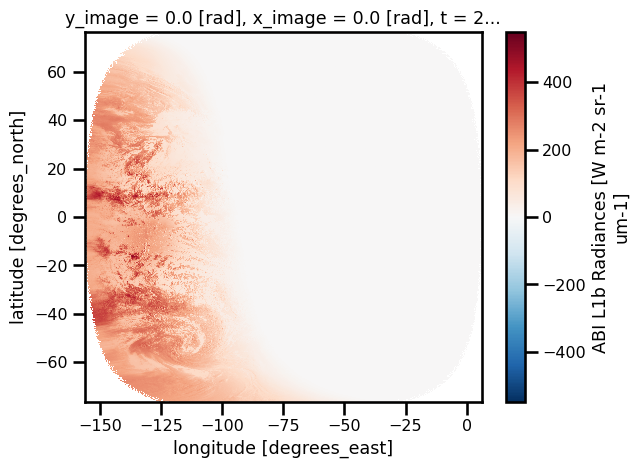

In [48]:
xr_da.plot.imshow()

In [42]:
xr_da

<xarray.DataArray 'Rad' (y: 10513, x: 11173)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * x                       (x) float64 -156.3 -156.3 -156.2 ... 6.096 6.111
  * y                       (y) float64 76.4 76.38 76.37 ... -76.38 -76.39
    y_image                 float32 0.0
    x_image                 float32 0.0
    t                       datetime64[ns] 2020-10-19T00:05:03.716449024
    goes_imager_projection  int64 0
Attributes:
    long_name:              ABI L1b Radiances
    standard_name:          toa_outgoing_radiance_per_unit_wavelength
    sensor_band_bit_depth:  10
    valid_range:            [   0 1022]
    units:                  W m-2 sr-1 um-1
    resolution:             y: 0.000028 rad x: 0.000028 rad
    grid_mapping:           goes_imager_projection
    cell_methods:           t: point area: point
    ancillary_variables:    DQF

In [44]:
xr_da.rio.crs

CRS.from_epsg(4326)

In [46]:
xr_source = XarraySource(xr_da, crs_transformer=xr_da.rio.crs)

ValueError: If temporal=False, data_array must have 3 dimensions: "x", "y", and "band" (in any order).

In [47]:
xr_da

<xarray.DataArray 'Rad' (y: 10513, x: 11173)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * x                       (x) float64 -156.3 -156.3 -156.2 ... 6.096 6.111
  * y                       (y) float64 76.4 76.38 76.37 ... -76.38 -76.39
    y_image                 float32 0.0
    x_image                 float32 0.0
    t                       datetime64[ns] 2020-10-19T00:05:03.716449024
    goes_imager_projection  int64 0
Attributes:
    long_name:              ABI L1b Radiances
    standard_name:          toa_outgoing_radiance_per_unit_wavelength
    sensor_band_bit_depth:  10
    valid_range:            [   0 1022]
    units:                  W m-2 sr-1 um-1
    resolution:             y: 0.000028 rad x: 0.000028 rad
    grid_mapping:           goes_imager_projection
    cell_methods:           t: point area: point
    ancillary_variables:    DQF